Thanks to : https://www.kaggle.com/rajnaruka0698/border-crossing-eda 

**Here, apart from data visualization, I create a custom class called Arima to grid search and identify best parameters(p and q) with the lowest AIC, BIC, and HQIC. The best model is then used for forecasting.**

In this article, we predict/forecast the number of crossings that arrive in the USA from Canada and Mexico borders for a particular period of time. The dataset used is the Bureau of Transportation Statistics (BTS) Border Crossing Data which provides summary statistics for inbound crossings at the U.S.-Canada and the U.S.-Mexico border at the port level. Data are available for trucks, trains, containers, buses, personal vehicles, passengers, and pedestrians. Border crossing data are collected at ports of entry by U.S. Customs and Border Protection (CBP). The data reflect the number of vehicles, containers, passengers or pedestrians entering the United States. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import plotly.graph_objects as go
import plotly.express as px
df = pd.read_csv("../input/border-crossing-entry-data/Border_Crossing_Entry_Data.csv")
print(df.shape)
df.head()

(346733, 8)


,Port Name,State,Port Code,Border,Date,Measure,Value,Location
0,Calexico East,California,2507,US-Mexico Border,03/01/2019 12:00:00 AM,Trucks,34447,POINT (-115.48433000000001 32.67524)
1,Van Buren,Maine,108,US-Canada Border,03/01/2019 12:00:00 AM,Rail Containers Full,428,POINT (-67.94271 47.16207)
2,Otay Mesa,California,2506,US-Mexico Border,03/01/2019 12:00:00 AM,Trucks,81217,POINT (-117.05333 32.57333)
3,Nogales,Arizona,2604,US-Mexico Border,03/01/2019 12:00:00 AM,Trains,62,POINT (-110.93361 31.340279999999996)
4,Trout River,New York,715,US-Canada Border,03/01/2019 12:00:00 AM,Personal Vehicle Passengers,16377,POINT (-73.44253 44.990010000000005)


There are about 345k entries in the dataset ranging from the 1st January, 1996 to the 1st March 2019. There are 8 columns. 

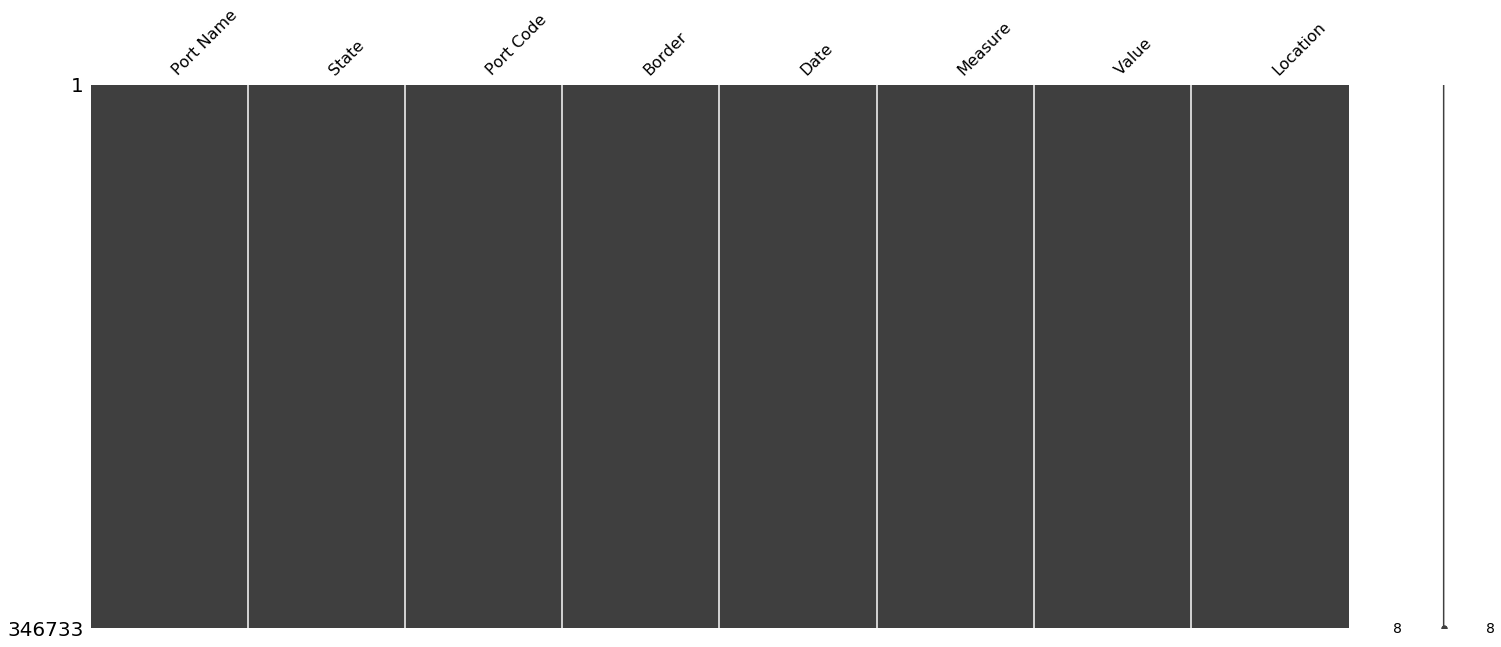

In [2]:
import missingno as msno
msno.matrix(df)

From the missingno plot, we see there are no missing values for any of the features. Let's modify the date column from string format to datetime format. Additionally, let's extract Year and Month from date, create separate columns for them in our dataframe, and we will use them later on.

In [3]:
    
df['Date'] = pd.to_datetime(df['Date'])
def addYearMonthColumn(dataframe):

    dataframe['Year'] = dataframe['Date'].apply(lambda x : x.year)

    month_mapper = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun'
                   ,7:'Jul', 8:'Aug', 9:'Sep' ,10:'Oct', 11:'Nov', 12:'Dec'}
    dataframe['Month'] = dataframe['Date'].apply(lambda x : x.month).map(month_mapper)
    
    del month_mapper
    return dataframe

df = addYearMonthColumn(df)
df.sample(5)

,Port Name,State,Port Code,Border,Date,Measure,Value,Location,Year,Month
247033,Richford,Vermont,203,US-Canada Border,2002-09-01,Personal Vehicle Passengers,23382,POINT (-72.66 45.02),2002,Sep
234057,Ogdensburg,New York,701,US-Canada Border,2003-07-01,Trains,0,POINT (-75.46 44.73),2003,Jul
15766,Oroville,Washington,3019,US-Canada Border,2017-08-01,Personal Vehicle Passengers,53717,POINT (-119.43444 48.93917),2017,Aug
70740,Tornillo-Fabens,Texas,2404,US-Mexico Border,2013-10-01,Truck Containers Empty,0,POINT (-106.14 31.429999999999996),2013,Oct
89582,Walhalla,North Dakota,3407,US-Canada Border,2012-08-01,Rail Containers Full,0,POINT (-97.91000000000001 49),2012,Aug


We'll observe the inbound traffic to US by 'Measure'. The unique values of 'Measure' columns are: 'Trucks', 'Rail Containers Full', 'Trains','Personal Vehicle Passengers', 'Bus Passengers','Truck Containers Empty', 'Rail Containers Empty', 'Personal Vehicles', 'Buses', 'Truck Containers Full','Pedestrians', 'Train Passengers'

In [4]:
df.Measure.unique()

array(['Trucks', 'Rail Containers Full', 'Trains',
       'Personal Vehicle Passengers', 'Bus Passengers',
       'Truck Containers Empty', 'Rail Containers Empty',
       'Personal Vehicles', 'Buses', 'Truck Containers Full',
       'Pedestrians', 'Train Passengers'], dtype=object)

In [5]:
def inboundTraffic(dataframe):
    resultDf = pd.DataFrame(dataframe.groupby(by='Measure')['Value'].sum().sort_values(ascending=False)).reset_index()
    fig = px.bar(resultDf, x='Measure', y='Value', height=400,color='Value', color_continuous_scale=px.colors.sequential.Magenta)
    fig.show()
    del resultDf
    
inboundTraffic(df)

Above bar plot shows most inbound traffic are due to personal vehicle pessengers and personal vehicles. We'll now check out the distribution of 'Measure' in the 2 border regions (Canada and Mexico).

In [6]:
import plotly.graph_objects as go

resultDf = df.groupby(by=['Border','Measure'])['Value'].sum().reset_index()
canada = resultDf.loc[resultDf['Border'] == 'US-Canada Border']['Value']
mexico = resultDf.loc[resultDf['Border'] == 'US-Mexico Border']['Value']

measures = resultDf['Measure']

fig = go.Figure()
fig.add_trace(go.Bar(
    x=measures,
    y=canada,
    name='Canada Border',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=measures,
    y=mexico,
    name='Mexico Border',
    marker_color='lightsalmon'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()


From this comparison bar plot, personal vehicle pessengers and personal vehicles have higher values in both the borders but there is higher traffic from Mexico. However, greater number of trucks and full container trucks arrive from Canada.
The pie charts below depicts the total number of crossings in percentage by border and measure. Here we see clearly that Mexico dominates the inbound traffic to USA and the lion's share of traffic is in the form of personal vehicle pessengers and personal vehicles.

In [7]:
def pieChart(dataframe, feature):
    resultDf = dataframe.groupby(by=feature)['Value'].sum()
    fig = go.Figure(data=[go.Pie(labels = resultDf.index, values=resultDf.values)])
    fig.update_traces(textfont_size=15,  marker=dict(line=dict(color='#000000', width=2)))
    fig.show()
    del resultDf

pieChart(df, 'Border')
pieChart(df,'Measure')

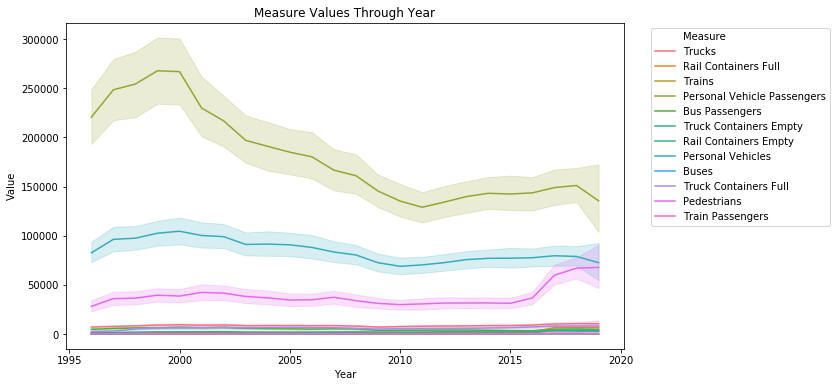

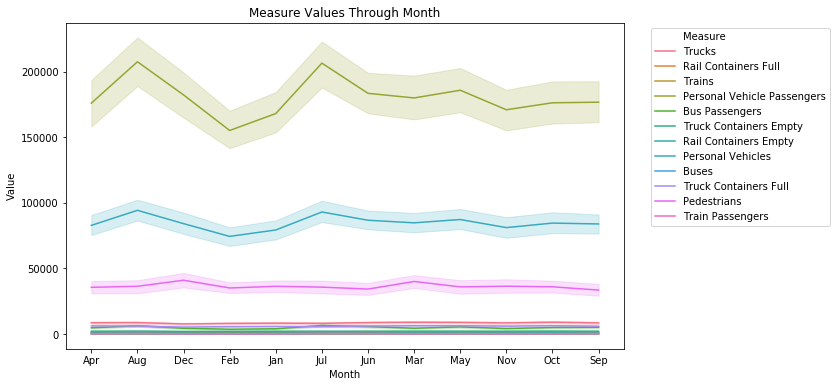

In [8]:
def measure_values_by_years(dataframe, time_feature):
    
    plt.figure(figsize=(10,6))
    sns.lineplot(data=dataframe, x=time_feature, y='Value', hue='Measure',legend='full')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title('Measure Values Through ' + time_feature)
measure_values_by_years(df, 'Year')
measure_values_by_years(df, 'Month')

Above charts show number of crossings throughout years and months respectively. Despite a decrease in crossings since 2000, a slight increment in pedestrians crossing over past few yers is observed after 2015. When analyzing crossings by month, July and August have highest crossings and February has the least number of crossings.

In [9]:
def crossing_by_post(data):
    resultDf = pd.DataFrame(data.groupby(by='Port Name')['Value'].sum().sort_values(ascending=False)).reset_index()
    fig = px.bar(resultDf, x='Port Name', y='Value', color='Value', color_continuous_scale=px.colors.sequential.Viridis) 
    fig.show()
crossing_by_post(df)

Above graph represents ports and their number of crossings, with El Paso showing the most traffic and Boquillas showing the least traffic.

We also group measures by their size. Below there are two bar plots with sum of values of different size of measures by different states. We follow the following mapping to groups measures by their size:
1. 'Trucks' : 'Mid_Size', 
2. 'Rail Containers Full' : 'Mid_Size', 
3. 'Trains' : 'Big_Size',
4. 'Personal Vehicle Passengers':'Small_Size', 
5. 'Bus Passengers':'Small_Size',
6. 'Truck Containers Empty':'Mid_Size', 
7. 'Rail Containers Empty':'Mid_Size',
8. 'Personal Vehicles' : 'Small_Size', 
9. 'Buses' : 'Mid_Size', 
10. 'Truck Containers Full' : 'Mid_Size',
11. 'Pedestrians':'Small_Size', 
12. 'Train Passengers':'Small_Size'

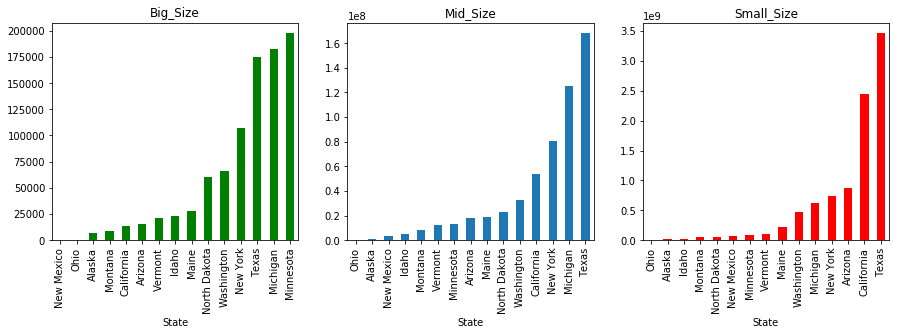

In [10]:
measure_size = {'Trucks' : 'Mid_Size', 'Rail Containers Full' : 'Mid_Size', 'Trains' : 'Big_Size',
       'Personal Vehicle Passengers':'Small_Size', 'Bus Passengers':'Small_Size',
       'Truck Containers Empty':'Mid_Size', 'Rail Containers Empty':'Mid_Size',
       'Personal Vehicles' : 'Small_Size', 'Buses' : 'Mid_Size', 'Truck Containers Full' : 'Mid_Size',
       'Pedestrians':'Small_Size', 'Train Passengers':'Small_Size'}

df['Size'] = df['Measure'].map(measure_size)

def crossing_by_measure_size(data):

    resultDf = data.groupby(by=['Size','State'])['Value'].sum().unstack()
    resultDf.fillna(0,inplace=True)

    plt.figure(figsize=(15,4))

    plt.subplot(131)
    resultDf.iloc[0].sort_values().plot(kind='bar', color='g')
    plt.xticks(rotation=90)
    plt.title('Big_Size')

    plt.subplot(132)
    resultDf.iloc[1].sort_values().plot(kind='bar')
    plt.xticks(rotation=90)
    plt.title('Mid_Size')

    plt.subplot(133)
    resultDf.iloc[2].sort_values().plot(kind='bar', color='red')
    plt.xticks(rotation=90)
    plt.title('Small_Size')

    del resultDf
    
crossing_by_measure_size(df)

## Insights :
- Minnesota has most number of big_size crossings but has averege on the other two categories.
- Arizona has good number of small size crossings but average on the other two categories.
- Ohio, Alaska and Montana has least amount of crossings in all the categories.
- Michigan has 2nd heighest BIg and Mid size crossings but comparitively less small size crossings. For the small-size crossings California takes the 2nd place.
- Texas has most mid_size and small size crossings and also, 3rd largest big_size crossings. This means there is considerable traffic into Texas.
- New York also has good number of crossings in all the three size crossing categories.

We now check for seasonal variations of incoming traffic based on measure-size.

<Figure size 1080x432 with 0 Axes>

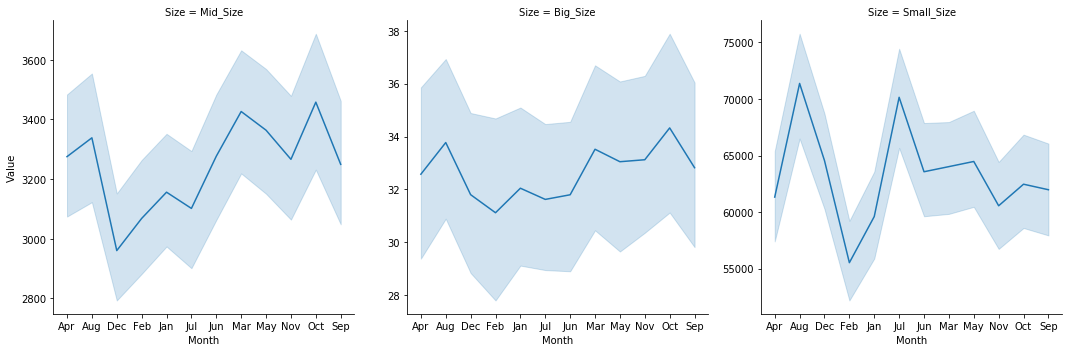

<Figure size 1080x432 with 0 Axes>

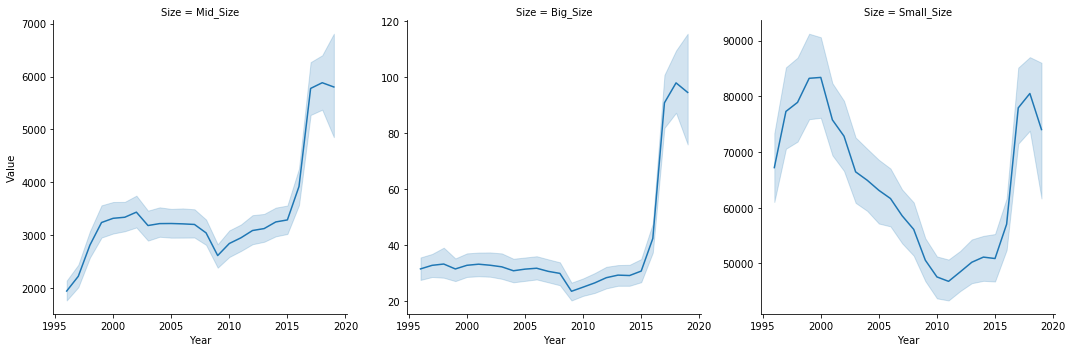

In [11]:
def seasonality_check(data, timeLabel):
    plt.figure(figsize=(15,6))
    g = sns.FacetGrid(data=data, col='Size', sharey=False, height=5, aspect=1)
    g.map(sns.lineplot, timeLabel, 'Value')
    
seasonality_check(df,'Month')
seasonality_check(df,'Year')

## Insights :
- Mid_Size crossings are least in December, January and July and most in October, March and August.
- Big_Size crossings are least in February and most in October, March and August.
- Small_Size crossings are least in January and February and most in August and July.
- For the yearly variation, all size categories show marked increase in traffic after 2015. The years around 2010 have witnessed the least amount of traffic.

For our ARIMA model, we need to create a time series data with dates and the associated incoming traffic( values). Plotting our time series, we see that after 2002 there's a declining trend in the traffic which slightly picks up after 2014. Also, we can easily observe a yearly pattern (seasonality) where traffic is  generally low during the beginning and the end of a year but is high during mid-year.


(279, 1)
               Value
Date                
1996-01-01  32550342
1996-02-01  32212625
1996-03-01  35509073
1996-04-01  35690321


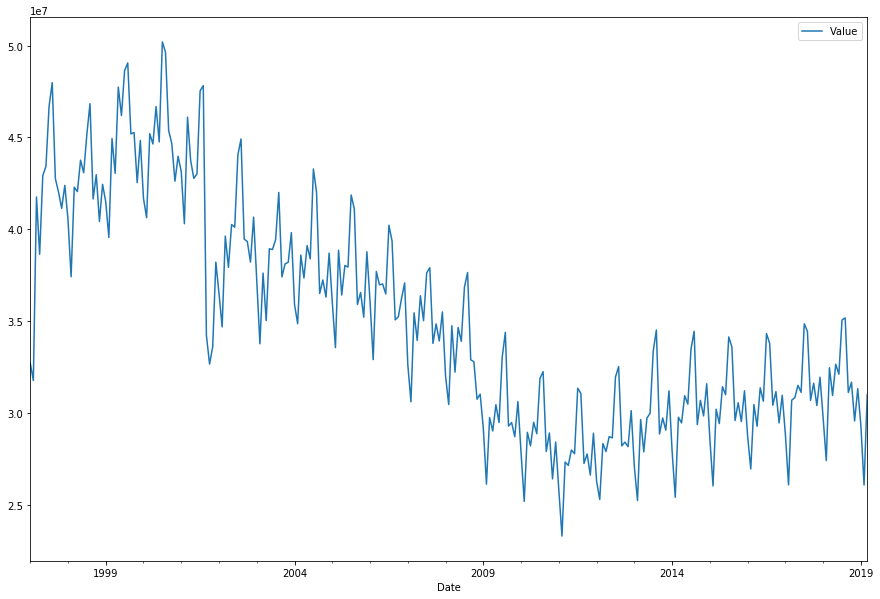

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts = df[['Date','Value']].groupby('Date').sum()
print(ts.shape)
print(ts.head(4))
ts = ts.loc['1997':]
ts.plot(figsize = (15,10))

Following is the decomposition of our time series data into trend, seasonality, and residuals. Since we observe that decreasing trend also decreases the seasonality, our time series is multiplicative. Due to the existence of trend, and seasonality, the data isn't stationary. We also check stationarity with the 'adfuller' test where the p-value>0.005 means the data is non-stationary whereas p-value<0.005 means the data is stationary. 

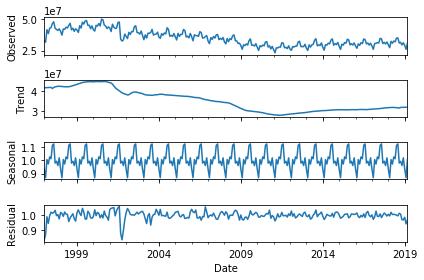

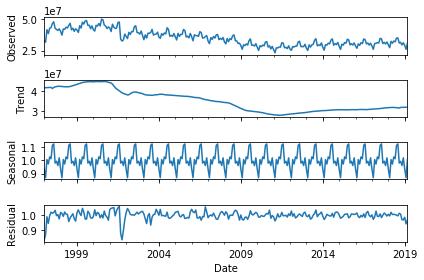

In [13]:
# Multiplicative Decomposition 

ts_mult_decomposition = seasonal_decompose(ts, model='multiplicative', extrapolate_trend='freq')
ts_mult_decomposition.plot()

In [14]:
#ts_trend = ts_mult_decomposition.trend * ts_mult_decomposition.resid
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts.Value.dropna())
print('p-value: %f' % result[1])

result = adfuller(ts.diff().Value.dropna())
print('p-value: %f' % result[1])

p-value: 0.560773
p-value: 0.000001


The p-value for unchanged time-series dataset is 0.56 meaning it's non-stationary. We make such time series stationary by differencing. After applying differencing once, the p-value of modified time series is 0.000001 < 0.005, meaning the data has become stationary. We can conclude that in our ARIMA model we have to set the differencing factor, d=1 to difference the data. We also need to determine the values of p-factor  (significant lag of PACF) and q-factor (significant lag of ACF). For this reason we draw the ACF and PACF plots for the unmodified and one-time-differenced time series data.

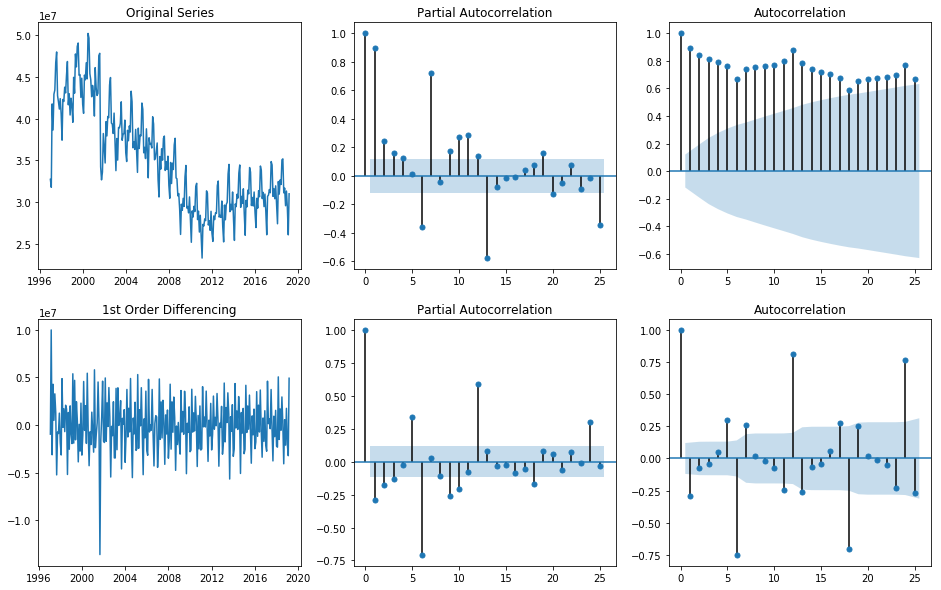

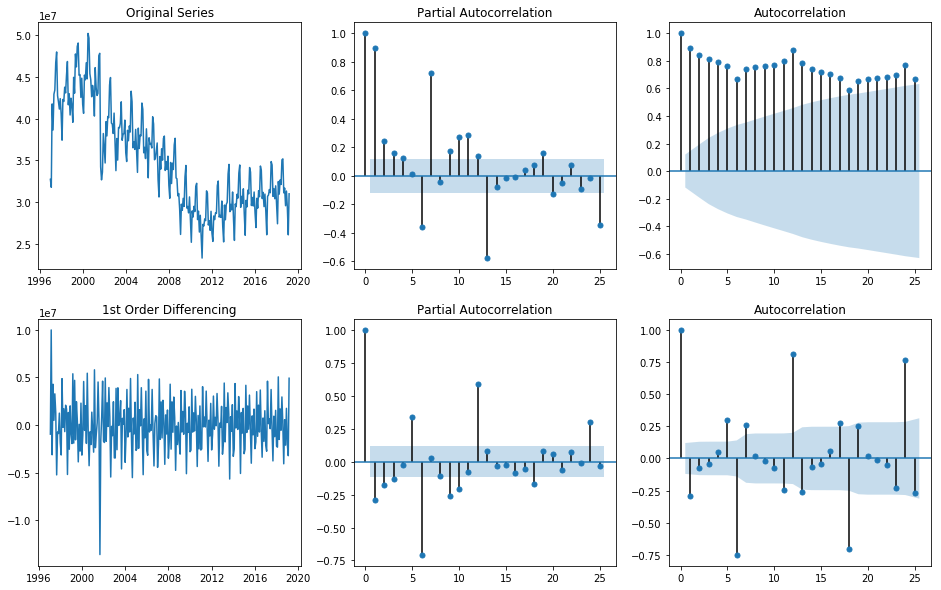

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(2, 3, figsize=(16,10))

axes[0, 0].plot(ts.Value)
axes[0, 0].set_title('Original Series')
plot_pacf(ts, ax=axes[0, 1])
plot_acf(ts, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(ts.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(ts.diff().dropna(), ax=axes[1, 1])
plot_acf(ts.diff().dropna(), ax=axes[1, 2])



Unmodified data has a lot of significant lags compared to one-time-differenced data meaning we need differencing in our ARIMA model to prevent overfitting/ complicating our model. To get the best model, we perform grid search with both p and q having value range between 0 and 2. The best model is chosen based on the lowest values for the metrics AIC, BIC, and HQIC. If any 2 of them, for a model, are lower than the previously calculated best metrics, that model is considered the new best model. For the training of our ARIMA model we only use the trend and the residual of time series data. The seasonality will be multiplied later during the plotting of our forecast.

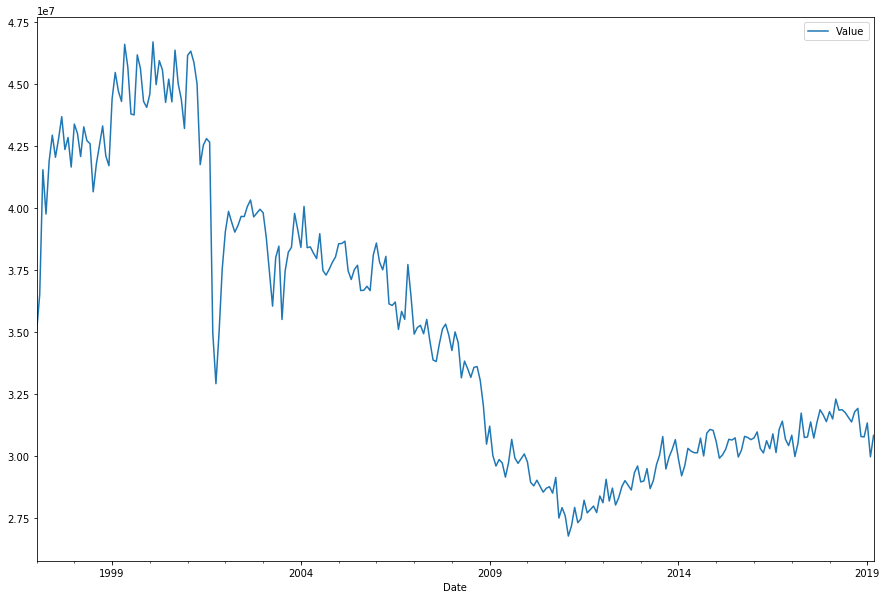

(267, 1)

In [16]:
def plot_trand_and_residual():
    trainingData = ts_mult_decomposition.trend * ts_mult_decomposition.resid
    trainingData.plot(figsize = (15,10))

    plt.show()
    return trainingData

training = plot_trand_and_residual()
training.shape

In [17]:
from statsmodels.tsa.arima_model import ARIMA

class Arima:
  def __init__(self, train_data, p,q,d=1):
    self.train_data = train_data
    self.p = p
    self.q=q
    self.d = d
    self.best_aic = np.Inf
    self.best_bic =np.Inf
    self.best_hqic = np.Inf
    self.best_order = (0,0,0)
    self.models = []
    self.model = 0
  
  def is_current_best_model(self):
    no_of_lower_metrics = 0
    if self.model.aic <= self.best_aic: no_of_lower_metrics+=1
    if self.model.bic <= self.best_bic: no_of_lower_metrics+=1
    if self.model.hqic <= self.best_hqic:no_of_lower_metrics+=1
    return no_of_lower_metrics >= 2

  def best_selection(self):
    for p_ in self.p:
        for q_ in self.q:
            
            currentOrder = (p_,q_)
            print("Current Order (p,q): "+ str(currentOrder))

            self.model = ARIMA(des, order=(1,0,1)).fit(disp=0)
            self.models.append(self.model)


            if self.is_current_best_model() == True:
                self.best_aic = np.round(self.model.aic,0)
                self.best_bic = np.round(self.model.bic,0)
                self.best_hqic = np.round(self.model.hqic,0)
                self.best_order = (p_,self.d,q_)
                current_best_model = self.model
                self.models.append(self.model)
                print('========================================================================')
                print("Best model so far: ARIMA" +  str(self.best_order) + 
                      " AIC:{} BIC:{} HQIC:{}".format(self.best_aic,self.best_bic,self.best_hqic)+
                      " resid:{}".format(np.round(np.exp(current_best_model.resid).mean(),3)))
                print('========================================================================')
                print()


    print('\n')
    print(current_best_model.summary())                
    return current_best_model, self.models 

x=range(2)
arima =Arima(training, x,x)
best_model, models = arima.best_selection()
best_model.plot_predict()
plt.title('Best Model')
plt.show()

Current Order (p,q): (0, 0)


NameError: name 'des' is not defined

Our best model has a p and q value of 1 meaning the model uses only one significant lag from PACF and ACF respectively. The best model's prediction(from 1997 to 2019) fits quite well with the training data. Now we forecast traffic values for the near future (2019 to 2020). During forecasting, we multiply the seasonal/yearly repeating component back to both the training data and the prediction to see how our forecast will actually look like considering trend, seasonality and residuals.

In [18]:
def make_seasonal(ts,tms) :
    seasonal_series = ts * tms # Include the seasonality
    seasonal_series = seasonal_series[~seasonal_series.isnull()] # trim extra values
    return seasonal_series

def create_seasonal_component():
    seasonal = ts_mult_decomposition.seasonal.loc['2016-01-01':'2016-12-01'].values # seasonal component, we take the 2016 ones, but they are all the same.
    seasonal = pd.Series(np.tile(seasonal.flatten(),11), index = pd.date_range(start='2019-01-01', end = '2029-12-01', freq='MS'))  # This is just a very long series with the seasonality.
    return seasonal

def create_forecast():
    tms = create_seasonal_component()
    model = ARIMA(training, order=(1,0,1))
    model_fit = model.fit(disp=0)

    fc_series, se_series, conf_series = model_fit.forecast(n_forecast)  # 2 sigma Confidence Level (95,55% conf)

    # Make as pandas series and include seasonality
    fc_series = make_seasonal(pd.Series(fc_series, index = date_rng),tms)
    lower_series = make_seasonal(pd.Series(conf_series[:, 0], index = date_rng),tms)
    upper_series = make_seasonal(pd.Series(conf_series[:, 1], index = date_rng),tms)
    
    return fc_series,lower_series,upper_series

def plot_forecast(fc_series,lower_series,upper_series):
    plt.figure(figsize=(12,5), dpi=100)

    plt.plot(training * ts_mult_decomposition.seasonal, label='Time Series Data', color='g')
    plt.plot(fc_series , label='Forecast',color='r')

    # Confidence level intervals
    plt.fill_between(lower_series.index,lower_series, upper_series, 
                     color='k', alpha=.15, label='2$\sigma$ Confidence level (95%)')
    plt.title('Forecast 2019/20')
    plt.legend(loc='upper left', fontsize=8)
    plt.xlim('2000', '2021')
    plt.show()
# Forecast

def draw_forecast_main():

    date_start = training.tail(1).index[0]
    date_end = '2020-12-01'
    print(date_start)
    date_rng = pd.date_range(start=date_start, end=date_end, freq='MS', closed = 'right') # range for forecasting
    n_forecast = len(date_rng) # number of steps to forecast
    print('range of dates: '+str(n_forecast))

    
    fc_series,lower_series,upper_series = create_forecast()

    
    plot_forecast(fc_series,lower_series,upper_series)
    
draw_forecast_main()

2019-03-01 00:00:00
range of dates: 21


/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



NameError: name 'n_forecast' is not defined

The forecast looks quite similar to the time series data meaning our model successfully captures the pattern(trend/seasonality/residuals) hidden within the dataset.